In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

Load results

In [3]:
# dir_single_query = '/home/chansingh/mntv1/single_query_anli_9_14' # this has longer strings
# dir_single_query = '/home/chansingh/mntv1/single_query_anli_9_16'
dir_single_query = '/home/chansingh/mntv1/single_query_anli_9_17'
# r = analyze_utils.load_results_and_cache(dir_single_query, save_file='r.pkl')
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = analyze_utils.postprocess_results(r_single_query)


# dir_suffix_search = '/home/chansingh/mntv1/suffix_anli_9_14' # this has longer strings
# dir_suffix_search = '/home/chansingh/mntv1/suffix_anli_9_16'
dir_suffix_search = '/home/chansingh/mntv1/suffix_query_anli_9_17'
# r_suffix_search = analyze_utils.load_results_and_cache(dir_suffix_search, save_file='r.pkl')
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = analyze_utils.postprocess_results(r_suffix_search)

r = pd.concat((r_single_query, r_suffix_search)).sort_values('checkpoint')
r.to_pickle(f'../results/prompt_gen/results_suffix_anli.pkl')

Plot relevant results

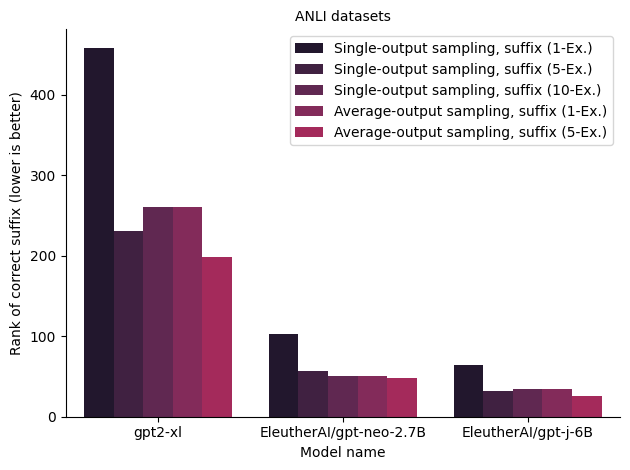

In [10]:
for metric_key in ['final_answer_pos_initial_token',
                  #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
   tab = analyze_utils.num_suffixes_checked_tab(r, metric_key=metric_key)
   analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets')

   if metric_key == 'final_answer_pos_initial_token':
      plt.savefig('../results/prompt_gen/anli_barplot.pdf', bbox_inches='tight')
      tab.to_pickle(f'../results/prompt_gen/tab_suffix_anli_{metric_key}.pkl')
   plt.show()

## Performance breakdowns

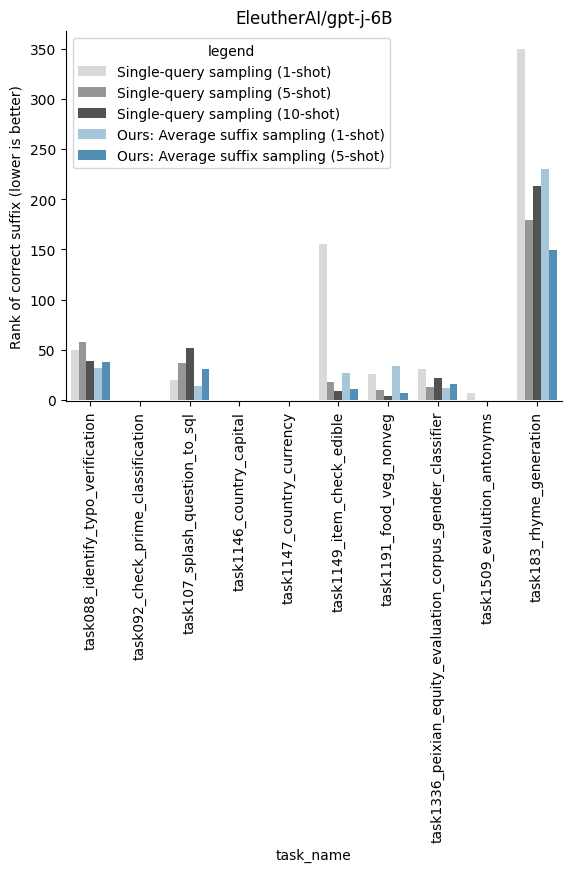

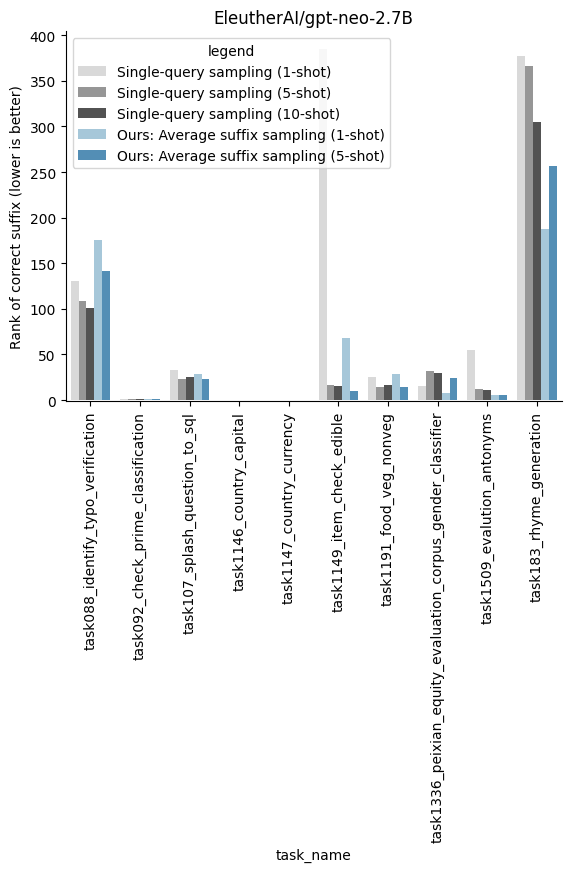

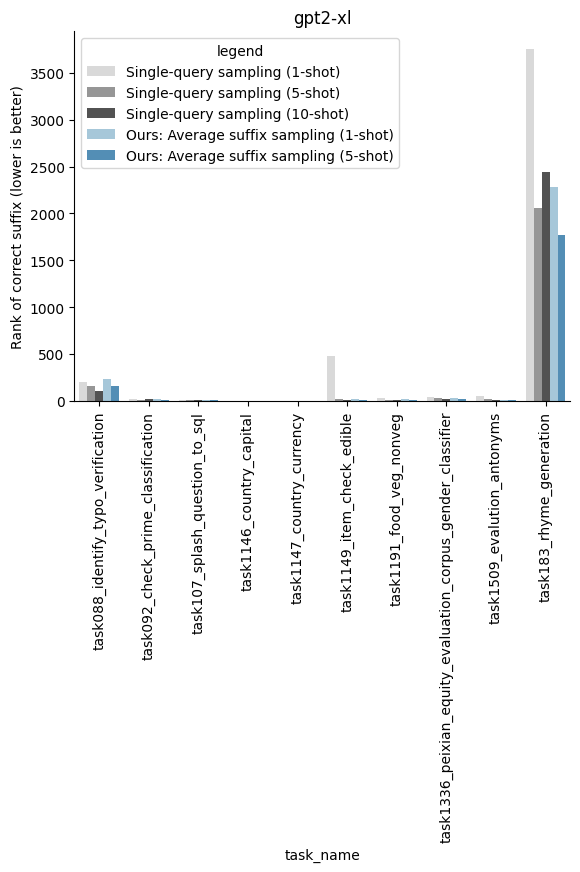

In [38]:
# cols_to_view = r_single_query.columns # cols_to_view
key_vars = ['checkpoint', 'n_shots', 'use_single_query', 'task_name']
cols_to_view = [col for col in r_single_query.columns if col.startswith('final')]


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(key_vars)[cols_to_view].mean().round(2)
    # display(rg[rg['final_answer_found'] < 1.0])
    # display(rg)
# r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries'] # look at templates

for checkpoint in rg.reset_index().checkpoint.unique():
    rp = rg.reset_index()
    # checkpoint = 'EleutherAI/gpt-j-6B'
    metric_key = 'final_answer_pos_initial_token'

    rp = rp[rp['checkpoint'] == checkpoint]
    rp['legend'] = rp['use_single_query'].map(
        analyze_utils.LEGEND_REMAP) + ' (' + rp['n_shots'].astype(str) + '-shot)'
    hue_order = analyze_utils.get_hue_order(rp['legend'])
    plt.title(checkpoint)
    sns.barplot(x='task_name', y=metric_key, hue_order=hue_order,
                hue='legend', data=rp, palette=analyze_utils.COLORS)  # data=tab[tab['n_shots'] == 1])
    plt.xticks(rotation='vertical')
    plt.ylabel(analyze_utils.YLABS.get(metric_key, metric_key))
    plt.gca().set_ylim(bottom=-1)
    plt.show()

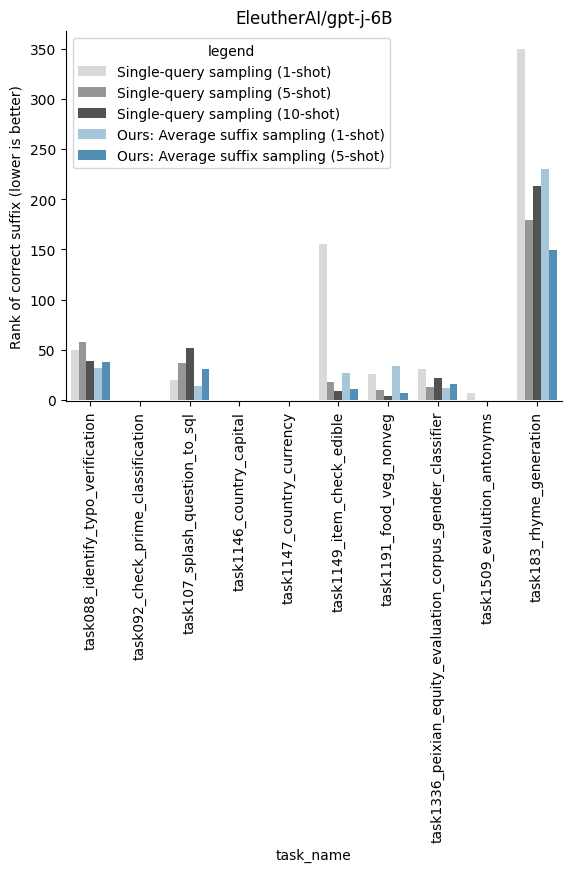

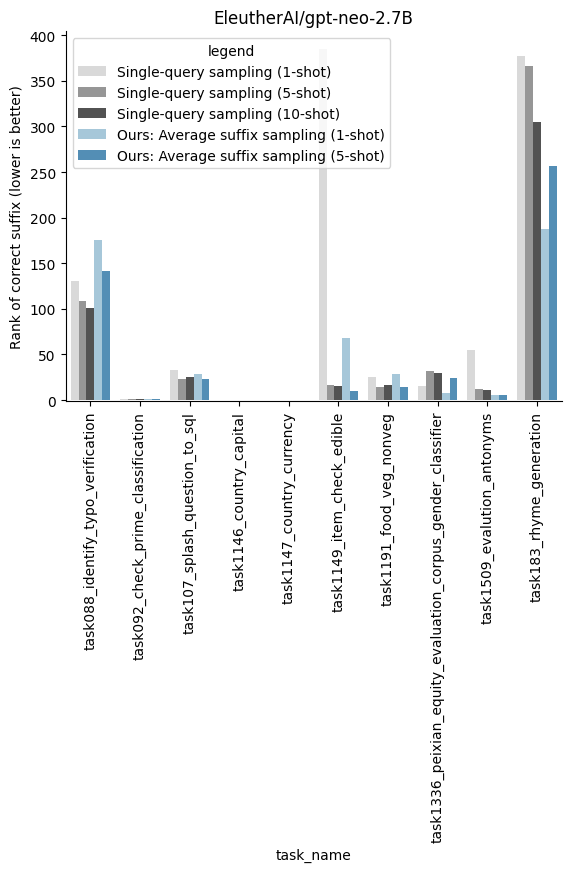

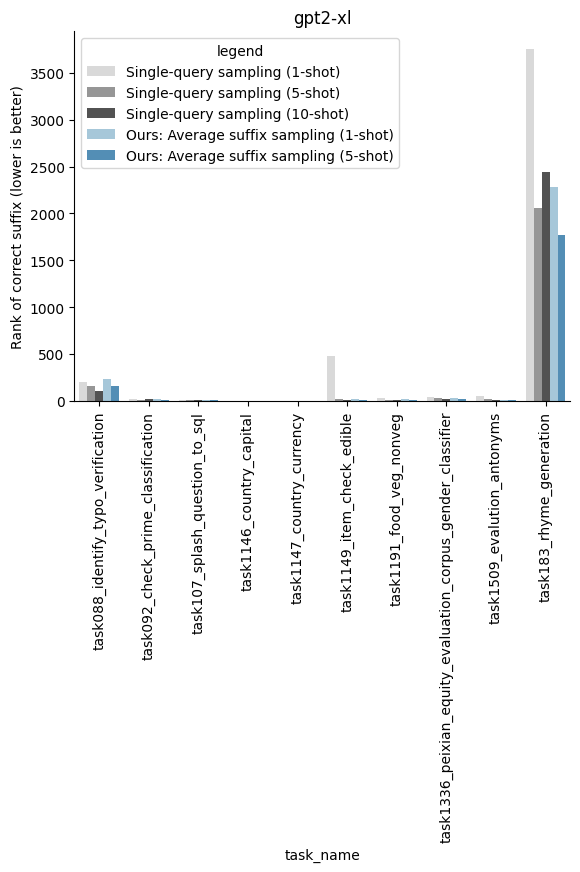